In [2]:
import numpy as np
import cv2
from imutils.object_detection import non_max_suppression
import pytesseract
from matplotlib import pyplot as plt

In [89]:
args = {"image":"C:/Users/maram/Desktop/prasad/Image-1.jfif", "east":"C:/Users/maram/Desktop/prasad/east_text_detection.pb", "min_confidence":0.5, "width":320, "height":320}

In [90]:
args['image'] = "C:/Users/maram/Desktop/prasad/Image-1.jfif"
image = cv2.imread(args['image'])
orig = image.copy()
(origH,origW) = image.shape[:2]
(newW,newH) = (args["width"], args["height"])
rW = origW/float(newW)
rH = origH/float(newH)
image = cv2.resize(image, (newW,newH))
(H,W) = image.shape[:2]
blob = cv2.dnn.blobFromImage(image,1.0,(W,H),(123.68, 116.78, 103.94), swapRB=True, crop=False )


In [91]:
net = cv2.dnn.readNet(args["east"])

In [92]:
layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]

net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

In [93]:
def predictions(prob_score, geo):
	(numR, numC) = prob_score.shape[2:4]
	boxes = []
	confidence_val = []

	# loop over rows
	for y in range(0, numR):
		scoresData = prob_score[0, 0, y]
		x0 = geo[0, 0, y]
		x1 = geo[0, 1, y]
		x2 = geo[0, 2, y]
		x3 = geo[0, 3, y]
		anglesData = geo[0, 4, y]

		# loop over the number of columns
		for i in range(0, numC):
			if scoresData[i] < args["min_confidence"]:
				continue

			(offX, offY) = (i * 4.0, y * 4.0)

			# extracting the rotation angle for the prediction and computing the sine and cosine
			angle = anglesData[i]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# using the geo volume to get the dimensions of the bounding box
			h = x0[i] + x2[i]
			w = x1[i] + x3[i]

			# compute start and end for the text pred bbox
			endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
			endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
			startX = int(endX - w)
			startY = int(endY - h)

			boxes.append((startX, startY, endX, endY))
			confidence_val.append(scoresData[i])

	# return bounding boxes and associated confidence_val
	return (boxes, confidence_val)

In [94]:
(boxes, confidence_val) = predictions(scores, geometry)
boxes = non_max_suppression(np.array(boxes), probs=confidence_val)

In [95]:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
results = []
# loop over the bounding boxes to find the coordinate of bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the coordinates based on the respective ratios in order to reflect bounding box on the original image
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	#extract the region of interest
	r = orig[startY:endY, startX:endX]

	#configuration setting to convert image to string.  
	configuration = ("-l eng --oem 1 --psm 8")
    ##This will recognize the text from the image of bounding box
	text = pytesseract.image_to_string(r,config=configuration)

	# append bbox coordinate and associated text to the list of results 
	results.append(((startX, startY, endX, endY), text))

ariel

FAIRY

VS

‘Bien



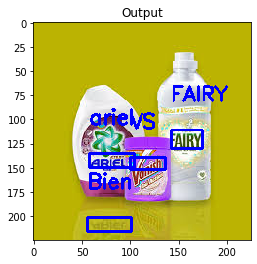

In [96]:
orig_image = orig.copy()

# Moving over the results and display on the image
for ((start_X, start_Y, end_X, end_Y), text) in results:
	# display the text detected by Tesseract
	print("{}\n".format(text))

	# Displaying text
	text = "".join([x if ord(x) < 128 else "" for x in text]).strip()
	cv2.rectangle(orig_image, (start_X, start_Y), (end_X, end_Y),
		(0, 0, 255), 2)
	cv2.putText(orig_image, text, (start_X, start_Y - 30),
		cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0,0, 255), 2)

plt.imshow(orig_image)
plt.title('Output')
plt.show()